In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import beta
import math

%matplotlib inline

# Contractual Setting Valuation

## Data Setup

In [7]:
survival_perc = [100.0, 64.3, 50.2, 41.5, 35.6, 31.1, 28.2, 25.4, 23.1, 21.0, 19.5, 19.5, 17.9]

CAC = 100 # Customer Acquisition Cost
AOR = 1.8  # Average Order Rate
RPO = 57.3 # Revenue per Order
CM = .26 # Contribution Margin
M = AOR * RPO * CM # Total Margin
WACC = 0.0153 # Discount Rate

## Data Imputation

In [23]:
St_actual = list(map(lambda x : x / 100, survival_perc))

T = len(St_actual)

Rt_actual = [i / j for i, j in zip(St_actual[1:T], St_actual[0:(T-1)])]
Rt_actual

lsts = {"month": range(1, T + 1), "St_actual": St_actual, "Rt_actual": [None] + Rt_actual}

d = pd.DataFrame(lsts)

t_calib = 6


## Geometric Model

### Function Definitions

In [39]:
def G_rt_sse(logit_theta: float, d: pd.DataFrame) -> float:
    theta = 1 / (1 + pow(-logit_theta, math.e))
    return sum(np.power((1 - theta) - d["Rt_actual"].iloc[1:],2))

### Calibration

In [57]:
theta = minimize(G_rt_sse, math.log(.1 / (1 - .1)), d[0:t_calib + 1])
theta["x"][0]
geom_theta_nls = 1 / (1 + pow(-theta["x"][0], math.e))

0.18523540024562138

Text(0.5, 0, 'Months (Since Acquisition)')

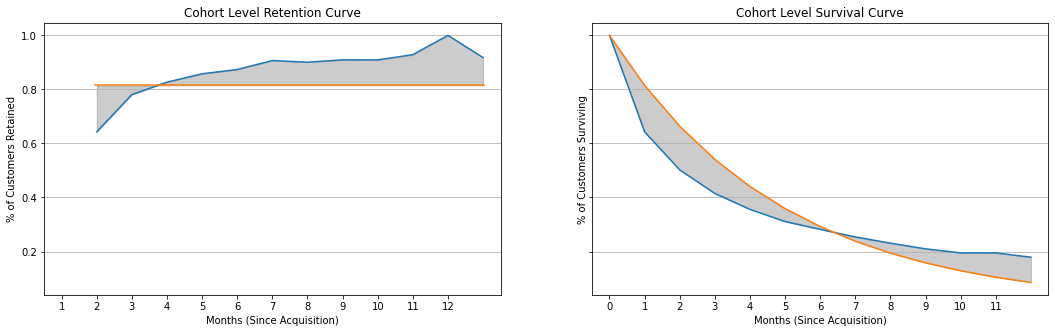

In [152]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(18, 5))

ax1.plot(d["month"], d["Rt_actual"])
ax1.axhline(1-geom_theta_nls, xmin = 1.5/13.5, xmax = 13/13.5, color = "C1")
ax1.fill_between(d["month"], d["Rt_actual"], 1 - geom_theta_nls, color = (0,0,0,0.2))
ax1.set_xlim(0.5, 13.5)
ax1.set_xticks(range(1, 13))
ax1.grid(axis = "y")
ax1.title.set_text("Cohort Level Retention Curve")
ax1.set_ylabel("% of Customers Retained")
ax1.set_xlabel("Months (Since Acquisition)")
# TODO: Add a legend
ax2.plot(d.index, d["St_actual"])
ax2.plot(d.index, np.power(1 - geom_theta_nls, range(0, T)))
ax2.fill_between(d.index, d["St_actual"], np.power(1 - geom_theta_nls, range(0, T)), color = (0,0,0,0.2))
ax2.set_xlim(-0.5, 12.5)
ax2.set_xticks(range(0, 12))
ax2.grid(axis = "y")
ax2.title.set_text("Cohort Level Survival Curve")
ax2.set_ylabel("% of Customers Surviving")
ax2.set_xlabel("Months (Since Acquisition)")


## Beta Geometric Model

### Function Definitions

In [188]:
def BG_rt(gamma: float, delta: float, t: int) -> float: 
    return ((delta + t - 1) / (gamma + delta + t - 1))

def BG_rt_sse(params: list, d: pd.DataFrame) -> float:
    gamma = pow(params[0], math.e)
    delta = pow(params[1], math.e)

    t = d.index[1:]
    Rt_actual = d["Rt_actual"].iloc[1:]

    pred = BG_rt(gamma, delta, t)

    return sum(pow(Rt_actual - pred, 2))

### Calibration

In [190]:
preds = minimize(BG_rt_sse, (1, 1), d[0:t_calib + 1])

gamma_nls = pow(preds["x"][0], math.e)
delta_nls = pow(preds["x"][1], math.e)

0.6769660030629567
1.2398727654836141


Text(0.5, 0, 'Churn Probability: ϴ')

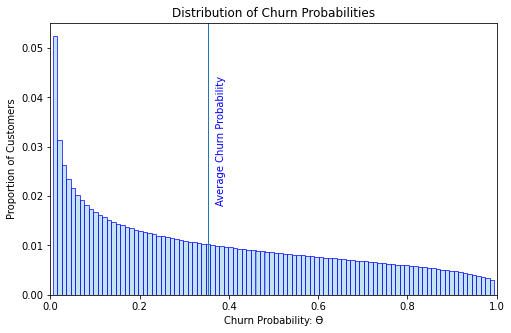

In [251]:
x = np.linspace(0, 1, 100)
m = beta.cdf(x, gamma_nls, delta_nls)
n = np.append(0, m)[:-1]
o = (m - n)[1:-1]
# TODO: Make this whole block more pythonic
lsts = {
        "p": np.linspace(0, 1, 100)[1:-1], 
        "cdf": beta.cdf(x, gamma_nls, delta_nls)[1:-1], 
        "cdf_diff": (beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls) - np.append(0, beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls))[:-1])[1:-1]
        }

data = pd.DataFrame(lsts)

fig, ax = plt.subplots(1, 1, figsize = (8, 5))

ax.bar(data["p"], data["cdf_diff"], width = 1/98, color = "lightblue", alpha = 0.7, edgecolor = "blue")
ax.axvline(gamma_nls / (gamma_nls + delta_nls), lw = 1)
ax.text(gamma_nls / (gamma_nls + delta_nls) * 1.05, max(data["cdf_diff"]) * 0.35, "Average Churn Probability", rotation = 90, color = "blue")
ax.set_xlim(0, 1)
ax.title.set_text("Distribution of Churn Probabilities")
ax.set_ylabel("Proportion of Customers")
ax.set_xlabel("Churn Probability: \u03F4")